
# Module 4 Session 4 - Health outcome modeling 

## Authors: Shivam Sharma

#### Date: May 29, 2024


## Section 1 - Data exploration

In [5]:
rm(list=ls())
set.seed(13)

library("data.table")
library("dplyr")
library("parallel")
library('stringr')
library('ggplot2')
library('forester')
library("IRdisplay")



options(repr.matrix.max.cols=50, repr.matrix.max.rows=100)
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 150)

In [6]:
# Load the files for our cohort.
cohort = as.data.frame(fread("../Data/Session4/ParticipantCohort.tsv"))
dim(cohort)
head(cohort)

a1c = as.data.frame(fread("../Data/Session4/ParticipantA1C.tsv"))
dim(a1c)
head(a1c)

t2d = as.data.frame(fread("../Data/Session4/ParticipantT2DStatus.tsv"))
dim(t2d)
head(t2d)

[1] 50000     4

,ParticipantID,Age,Sex,SIRE
,<int>,<dbl>,<chr>,<chr>
1,72855012,18.50098,F,Black
2,60709423,18.00000,F,Black
3,30963548,21.44716,F,Black
4,76818295,24.45020,F,Black
5,68693481,20.64606,F,Black
6,61809284,23.00696,F,Black


[1] 50000     2

,ParticipantID,A1C
,<int>,<dbl>
1,72855012,5.509368
2,60709423,6.166759
3,30963548,9.520273
4,76818295,3.344276
5,68693481,3.242426
6,61809284,5.525102


[1] 50000     2

,ParticipantID,T2DStatus
,<int>,<int>
1,10001701,0
2,10004576,0
3,10006792,0
4,10007268,0
5,10008364,0
6,10008475,1


In [7]:
# Merge the datasets together.
cohort = merge(cohort, a1c, by = "ParticipantID")
cohort = merge(cohort, t2d, by = "ParticipantID")

#Make SIRE as a categorical variable.
cohort$SIRE = factor(cohort$SIRE, level = c("White", "Black", "Hispanic"))

dim(cohort)
head(cohort)

[1] 50000     6

,ParticipantID,Age,Sex,SIRE,A1C,T2DStatus
,<int>,<dbl>,<chr>,<fct>,<dbl>,<int>
1,10001701,50.73368,M,White,4.538563,0
2,10004576,57.51144,F,Black,6.217039,0
3,10006792,52.70796,F,White,6.623903,0
4,10007268,49.73393,F,Hispanic,8.720656,0
5,10008364,43.61219,F,White,6.616829,0
6,10008475,66.53269,M,Hispanic,7.391317,1


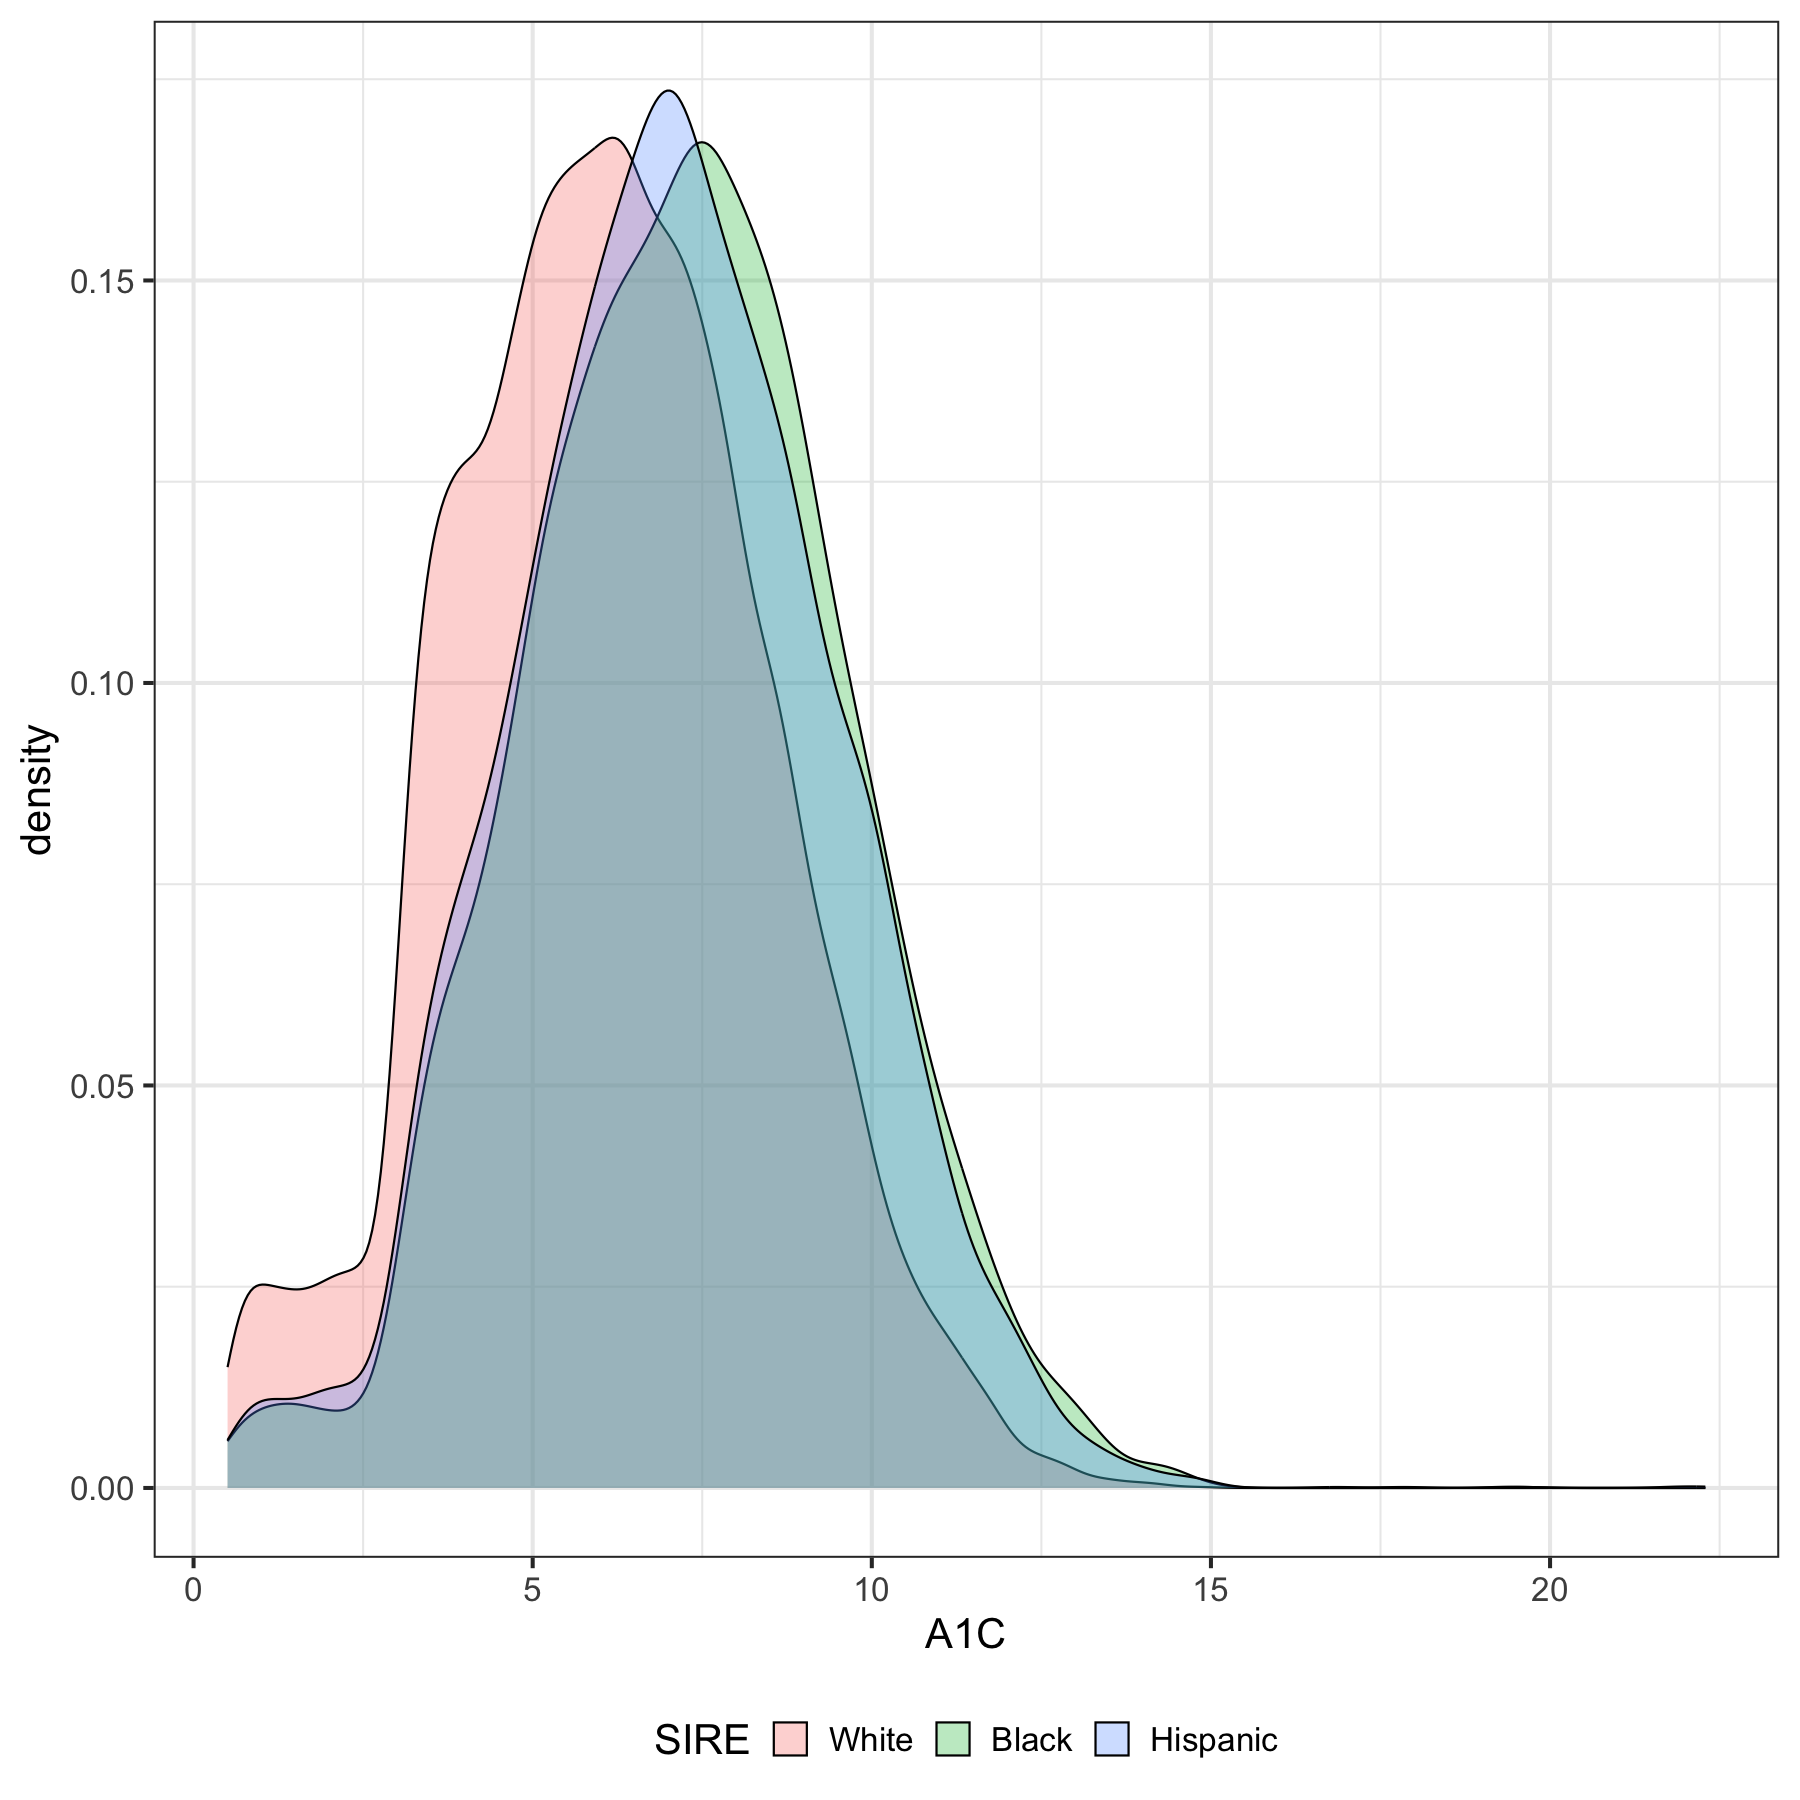

In [8]:
# Visualzie the density of age distribution.
ggplot(cohort, aes(x = A1C, fill = SIRE)) + 
    geom_density(alpha = 0.3) + 
    theme_bw(base_size = 20) + 
    theme(legend.position = "bottom")

In [9]:
# Summarize A1C by SIRE groups.
cohort %>% count(SIRE)

cohort %>%
    group_by(SIRE) %>%
    summarize(
        min = min(A1C),
        max = max(A1C),
        mean = mean(A1C),
        median = median(A1C)
    )

SIRE,n
<fct>,<int>
White,32145
Black,7429
Hispanic,10426


SIRE,min,max,mean,median
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
White,0.5013102,14.91318,6.140689,6.107355
Black,0.5203044,19.44811,7.287397,7.309758
Hispanic,0.5213856,22.28962,7.121485,7.077616


## Section 2 - Disparities between HbA1c levels 

In [10]:
# Create a linear model to test for A1C disparities.
mod <- lm(A1C ~ SIRE + Sex + Age, data = cohort)

summary_stats = summary(mod)$coefficients %>% as.data.frame()
summary(mod)


Call:
lm(formula = A1C ~ SIRE + Sex + Age, data = cohort)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.1987 -1.6037 -0.0311  1.5553 15.1601 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.974102   0.063713   78.07   <2e-16 ***
SIREBlack    1.108227   0.029738   37.27   <2e-16 ***
SIREHispanic 0.925206   0.026505   34.91   <2e-16 ***
SexM         0.352913   0.021629   16.32   <2e-16 ***
Age          0.022384   0.001337   16.75   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.304 on 49995 degrees of freedom
Multiple R-squared:  0.0558,	Adjusted R-squared:  0.05572 
F-statistic: 738.6 on 4 and 49995 DF,  p-value: < 2.2e-16


---
---

#### Technical considerations
+ SIRE is a categorical variable and results are shown relative to "White" group. This can be changed in the code cell above in the levels argument.
+ Similarly for Sex, the results are show relative to female.
+ Age on the other hand is continuous, so think in terms of "every 1 year increment"


#### Conclusions

+ SIRE = Black; A participant who identifies as Black in our dataset is likely to have 1.1 units higher A1C compared to a participant who identifies as "White" while adjusted for sex and age
+ SIRE = Hispanic; 0.9 units higher
+ Sex = Male; Male participants tend to have 0.35 units higher A1C than females within the SIRE groups and age ranges.
+ Age; For every 1 year added, there is an increment of 0.02 units in A1C levels in our dataset

In [11]:
# Get the confidence intervals for the coefficients.
conf_intervals <- confint(mod) %>% as.data.frame()
names(conf_intervals) = c("Low", "High")

summary_stats = merge(summary_stats, conf_intervals, by='row.names', all=TRUE)
names(summary_stats)[1] = "Variable"

# Round to 2 decimals
summary_stats = summary_stats %>% mutate_if(is.numeric, round, digits = 2)
head(summary_stats)

,Variable,Estimate,Std. Error,t value,Pr(>|t|),Low,High
,<I<chr>>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,(Intercept),4.97,0.06,78.07,0,4.85,5.10
2,Age,0.02,0.00,16.74,0,0.02,0.03
3,SexM,0.35,0.02,16.32,0,0.31,0.40
4,SIREBlack,1.11,0.03,37.27,0,1.05,1.17
5,SIREHispanic,0.93,0.03,34.91,0,0.87,0.98


In [20]:
forest_plot = forester(left_side_data = summary_stats[,c(1,2,5)],
           estimate = summary_stats$Estimate,
           ci_low = summary_stats$Low,
           ci_high = summary_stats$High,
           display = FALSE,
           justify = 0,
           xlim = c(-1, 5.2),
           font_family = "courier",
           point_sizes = 1,
                       ggplot_width = 50,
           file_path = here::here("ForestPlot.A1C.png")
        )

New names:
• `Estimate` -> `Estimate...2`
• `Estimate` -> `Estimate...5`


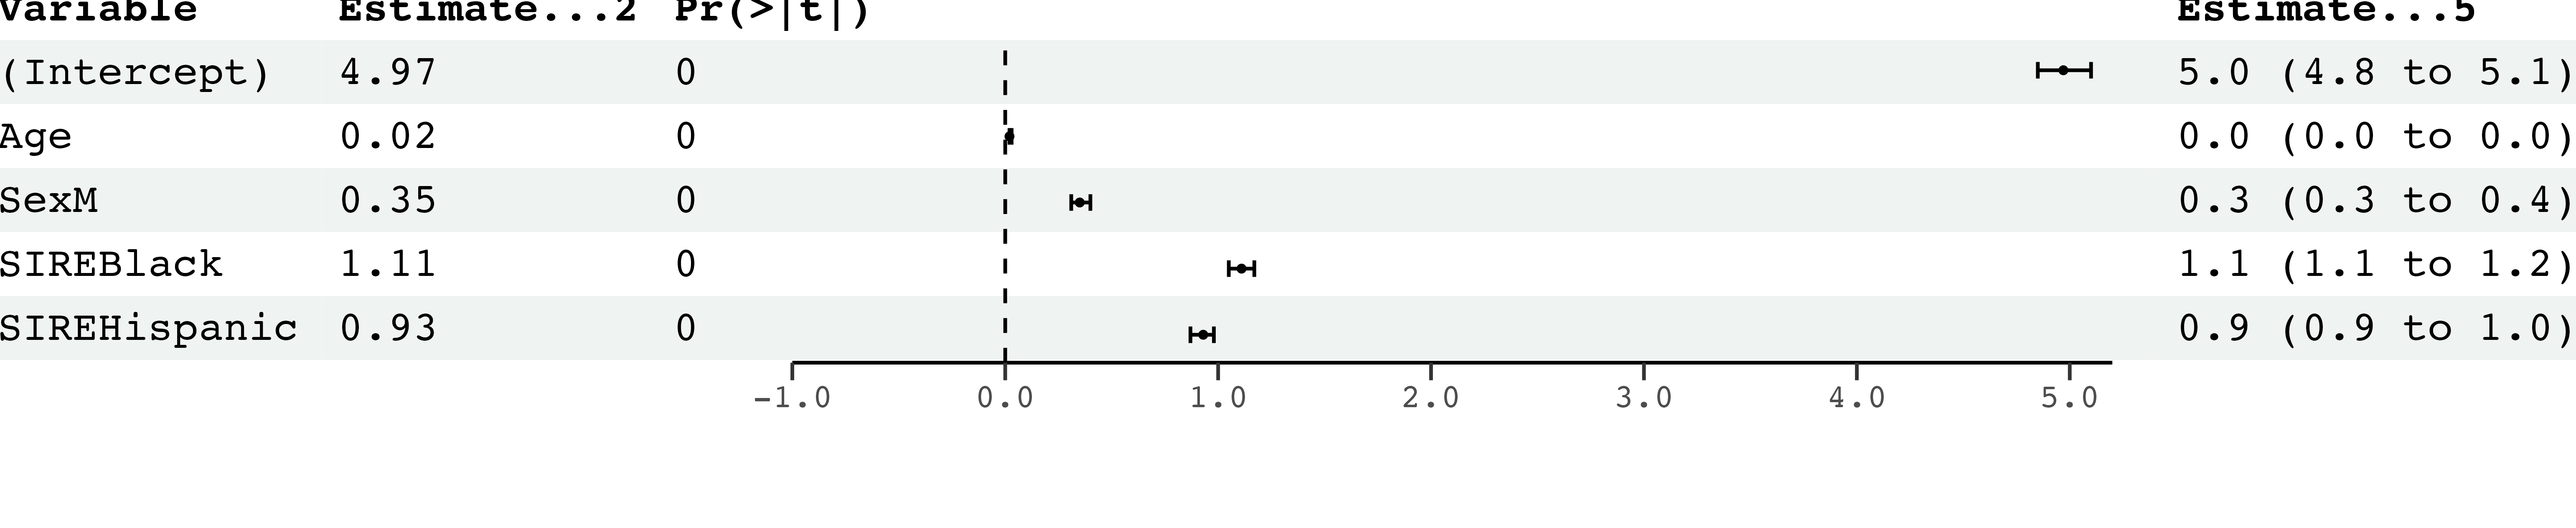

In [21]:
display_png(file = "../ForestPlot.A1C.png")  


## Section 3 - Disparities between type 2 diabetes 